***
*Project:* Helmholtz Machine

*Author:* Jingwei Liu, Computer Music Ph.D., UC San Diego
***

# <span style="background-color:darkorange; color:white; padding:2px 6px">MHM Pre</span> 

# Helmholtz Machine MNIST MIM


*Created:* April 13, 2025


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
torch.cuda.is_available()

True

In [2]:
def para_init(n_dz,dev):
    """
    Arguments:
    n_dz -- torch tensor of size len(n_dz)
    init_type -- "zero"

    Returns:
    Phi, Theta -- set of parameters for hierarchical layers
    """
    Phi = {}
    Theta = {}
    l = len(n_dz)
    for i in range(l-2):
        Phi["Phi_" + str(i) + str(i+1)] = torch.zeros((n_dz[i+1],n_dz[i]),device=dev)
    for i in range(l-1,0,-1):
        Theta["Theta_" + str(i) + str(i-1)] = torch.zeros((n_dz[i-1],n_dz[i]),device=dev)
    return Phi,Theta

In [3]:
def sigmoid(x):
    """
    Arguments:
    x -- torch tensor of shape (n,batch_size)
    
    Returns:
    p -- probability of layer y, torch tensor of shape (n,batch_size)
    """
    p = 1/(1+torch.exp(-x))
    return p

In [4]:
def one_step_forward(x,param):
    """
    Arguments:
    x -- input layer, torch tensor of shape (n_x,batch_size)
    param -- parameters from x to y. Torch tensor of shape (n_y,n_x)
    
    Returns:
    q -- probability of layer y, torch tensor of shape (n_y,batch_size)
    """
    x = x.type(torch.float)
    q = sigmoid(torch.matmul(param,x))
    return q

In [5]:
def sample(q,dev):
    """
    Arguments:
    q -- probability of layer y, torch tensor of shape (n_y,batch_size)
    dev -- device
    
    Returns:
    y -- instantiation of layer y, torch tensor of shape (n_y,batch_size)
    """
    y = (q > torch.rand(q.size(),device=dev)).long() # rejection sampling
    return y

In [6]:
def log(p):
    q = torch.where(p != 0, torch.log(p), -20) # replace log(0) with -100
    return q

In [7]:
def cross_entropy_loss(y,q):
    """
    Arguments:
    y -- output layer sample, torch tensor of shape (n_y,batch_size)
    q -- probability of layer y, torch tensor of shape (n_y,batch_size)
    
    Returns:
    loss -- cross entropy loss, L = -(y.*log(q)+(1-y).*log(1-q)).mean()
    """
    loss = -(y * log(q) + (1-y) * log(1-q)).mean()
    return loss

In [8]:
def one_step_update(x,y,param,lr):
    """
    Arguments:
    x -- input layer sample, torch tensor of shape (n_x,batch_size)
    y -- output layer sample, torch tensor of shape (n_y,batch_size)
    param -- parameters from x to y. Torch tensor of shape (n_y,n_x)
    lr -- learning rate
    
    Returns:
    grad -- gradient of parameters. Torch tensor of shape (n_y,n_x)
    param -- updated parameters from x to y. Torch tensor of shape (n_y,n_x)
    loss -- cross entropy loss, L = -(y.*log(q)+(1-y).*log(1-q)).mean()
    """
    batch_size = x.shape[1]
    q = one_step_forward(x,param)
    grad = torch.matmul(q-y,torch.t(x.type(torch.float)))/batch_size # weight by precision
    param = param - lr*grad
    loss = cross_entropy_loss(y,q)
    return param, grad, loss

In [9]:
def layer_wise_train(input_x,param_xy,param_yx,lr):
    """
    Arguments:
    input_x -- input layer sample, torch tensor of shape (n_x,batch_size)
    param_xy -- parameters from x to y. Torch tensor of shape (n_y,n_x)
    param_yx -- parameters from y to x. Torch tensor of shape (n_x,n_y)
    lr -- learning rate
    
    Returns:
    output_y -- output layer sample, torch tensor of shape (n_y,batch_size)
    param_yx -- updated parameters from y to x
    grad -- gradient of param_yx. Torch tensor of shape (n_x,n_y)
    loss -- cross entropy loss at layer x
    """
    # Compute output layer distribution
    q = one_step_forward(input_x,param_xy)
    
    # Sample the output layer
    output_y = sample(q,dev)
    
    # train the opposite phase from x to y
    param_yx, grad, loss = one_step_update(output_y,input_x,param_yx,lr)
    
    return output_y, param_yx, grad, loss

In [10]:
def wake_phase(Phi,Theta,data,lr,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    data -- input data. Torch tensor of shape (n_d,batch_size)
    lr -- learning rate
    dev -- torch device
    
    Returns:
    Theta -- updated sleep phase parameters.
    Grad -- set of gradients for Theta. len(Grad) = n_layer-1
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    batch_size = data.shape[1]
    input_x = data
    for i in range(n_layer-2):
        output_y, Theta["Theta_" + str(i+1) + str(i)], Grad, Loss[i] = \
        layer_wise_train(input_x,Phi["Phi_" + str(i) + str(i+1)],Theta["Theta_" + str(i+1) + str(i)],lr)
        input_x = output_y
    Theta["Theta_" + str(n_layer-1) + str(n_layer-2)], Grad, Loss[n_layer-2] = \
    one_step_update(torch.ones(1,batch_size,dtype=int,device=dev),input_x,Theta["Theta_" + str(n_layer-1) + str(n_layer-2)],lr)
    return Theta, Loss

In [11]:
def sleep_phase(Phi,Theta,gen_batch_size,lr,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    gen_batch_size -- number of generated samples in a batch
    lr -- learning rate
    dev -- torch device
    
    Returns:
    Phi -- updated sleep phase parameters.
    Grad -- set of gradients for Phi. len(Grad) = n_layer-2
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    unit = torch.ones(1,gen_batch_size,dtype=int,device=dev)
    input_x = sample(one_step_forward(unit,Theta["Theta_" + str(n_layer-1) + str(n_layer-2)]),dev)
    for i in range(n_layer-2,0,-1):
        output_y, Phi["Phi_" + str(i-1) + str(i)], Grad, Loss[i] = \
        layer_wise_train(input_x,Theta["Theta_" + str(i) + str(i-1)],Phi["Phi_" + str(i-1) + str(i)],lr)
        input_x = output_y
    return Phi, Loss

In [12]:
def one_step_prob_entropy(q):
    """
    Arguments:
    q -- probability of layer y, torch tensor of shape (n_y,batch_size)
    
    Returns:
    p_y -- Bernoulli probability of each neuron at layer Y. Torch tensor of shape (n_y,)
    H_Y -- factorial entropy at output layer Y, a tensor number
    H_YX -- conditional entropy from layer X to Y, a tensor number
    """
    p_yx = q.t()   # (batch_size,n_y)
    H_YX = entropy_bernoulli(p_yx).mean() # tensor number
    p_y = p_yx.mean(axis=0) # (n_y,)
    H_Y = entropy_bernoulli(p_y) # tensor number
    return H_Y, H_YX

In [13]:
def wake_sample(Phi,data,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    data -- input data. Torch tensor of shape (n_d,batch_size)
    dev -- torch device
    
    Returns:
    Recog_sample -- set of bottom-up samples for hierarchical layers. len(Recog_sample) = n_layer-2. For every layer, 
    """
    n_layer = len(Phi) + 2
    batch_size = data.shape[1]
    input_x = data
    Recog_sample = {}
    Recog_sample["Layer_" + str(0)] = data
    H_Y_wake = torch.zeros(n_layer-2)
    H_YX_wake = torch.zeros(n_layer-2)
    for i in range(n_layer-2):
        q = one_step_forward(input_x,Phi["Phi_" + str(i) + str(i+1)])
        H_Y_wake[i], H_YX_wake[i] = one_step_prob_entropy(q)
        input_x = sample(q,dev)
        Recog_sample["Layer_" + str(i+1)] = input_x
    return Recog_sample, H_Y_wake, H_YX_wake

In [14]:
def sleep_sample(Theta,gen_batch_size,dev):
    """
    Arguments:
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    gen_batch_size -- number of generated samples in a batch
    dev -- torch device
    
    Returns:
    Gen_sample -- set of top-down generations for hierarchical layers. len(Gen_sample) = n_layer-1. For every layer, 
                    gen_sample is of shape (n_y, gen_batch_size)
    """
    n_layer = len(Theta) + 1
    input_x = torch.ones(1,gen_batch_size,dtype=int,device=dev)
    Gen_sample = {}
    H_Y_sleep = torch.zeros(n_layer-1)
    H_YX_sleep = torch.zeros(n_layer-1)
    for i in range(n_layer-1,0,-1):
        q = one_step_forward(input_x,Theta["Theta_" + str(i) + str(i-1)])
        H_Y_sleep[i-1], H_YX_sleep[i-1] = one_step_prob_entropy(q)
        input_x = sample(q,dev)
        Gen_sample["Layer_" + str(i-1)] = input_x
    return Gen_sample, H_Y_sleep, H_YX_sleep

In [15]:
def decimalize(bnr,dev):
    """
    Arguments: bnr -- torch tensor of binary values {0,1}, of shape (width,n)
    Returns: dcm -- a decimalized intger tensor in range [0,2**width), shape (n,)
    """
    width = bnr.shape[0]
    dcm = (2**torch.arange(width).flip(0).to(dev).reshape(-1,1) * bnr).sum(axis=0)
    return dcm

In [16]:
def binarilize(dcm,width,dev):
    """
    Arguments: dcm -- a decimalized intger tensor in range [0,2**width), shape (n,)
    Returns:   bnr -- torch tensor of binary values {0,1}, of shape (width,n)
    """
    n = len(dcm)
    bnr = np.zeros((width,n),dtype=int)
    for i in range(n):
        bnr[:,i:i+1] = np.array(list(np.binary_repr(dcm[i], width=width))).astype(int).reshape(-1,1)
    bnr = torch.from_numpy(bnr).type(torch.int64).to(dev)
    return bnr

In [17]:
def entropy(row_dist):
    """
    Arguments: row_dist -- unnormalized row distribution. Torch tensor of shape (n_row, n_p) or (n_p,)
    Returns: H -- row entropy. Torch tensor of shape (n_row,1) or a number
    """
    if row_dist.ndim == 1:
        p = row_dist/row_dist.sum()
        H = (-p * log(p)).sum()
    else:
        P = row_dist/row_dist.sum(axis=1,keepdims=True)
        H = (-P * log(P)).sum(axis=1,keepdims=True)
    return H

In [18]:
def entropy_bernoulli(P_ber):
    """
    Arguments: P_ber -- multi-variate independent row Bernoulli distributions. Torch tensor of shape (n_row, n_p) or (n_p,)
    Returns: H_ber -- row Bernoulli entropy. Torch tensor of shape (n_row,1) or a number
    """
    entropy = - (P_ber * log(P_ber) + (1-P_ber) * log(1-P_ber))
    if P_ber.ndim == 1:
        H_ber = entropy.sum()
    else:
        H_ber = entropy.sum(axis=1,keepdims=True)
    return H_ber

In [19]:
def KL_divergence(p,q):
    """
    Arguments: probability distribution p,q. Torch tensors of shape (n,)
    Returns: KL-divergence (p*log(p/q)).sum()
    """
    if (p.ndim == 1) and (q.ndim == 1):
        D_KL = (p*log(p) - p*log(q)).sum()
    else:
        raise Exception('Dimension error')
    return D_KL

In [20]:
def KL_divergence_bernoulli(p,q):
    """
    Arguments: multi-variate independent Bernoulli distributions. Torch tensors of shape (n,)
    Returns: sum of n bernoulli variable KL-divergence (p*log(p/q)+(1-p)*log((1-p)/(1-q))).sum()
    """
    if (p.ndim == 1) and (q.ndim == 1):
        D_KL_bernoulli = (p*log(p) - p*log(q) + (1-p)*log(1-p) - (1-p)*log(1-q)).sum()
    else:
        raise Exception('Dimension error')
    return D_KL_bernoulli

In [21]:
def MI_sample_batch(input_x,param,eps,dev):
    """
    Arguments:
    input_x -- input layer sample, torch tensor of shape (n_x,batch_size)
    param -- parameters from x to y. Python dictionary of length n_mlp, of keys 0,1,2,...
    dev -- device
    
    Returns:
    output_y -- output layer sample, torch tensor of shape (n_y,1)
    """
    # H(Y|x)
    batch_size = input_x.shape[1]
    q = one_step_forward(input_x,param) # (n_y,batch_size)
    q_sample = (q > 0.5).long() # (n_y,batch_size)
    
    # minimum H(Y)
    p_y = q.mean(axis=1,keepdim=True) # (n_y,1)
    p_sample = (p_y < 0.5).long()
    output_y = sample(q,dev) # (n_y,batch_size)
    
    mask = ((q - 0.5).abs() - (p_y - 0.5).abs() > 0).long()
    y_sample = mask * q_sample + (1-mask) * p_sample
    
    output_y = y_sample
#     output_y[:,int(batch_size/2)] = y_sample[:,int(batch_size/2)]
    
    return output_y

In [22]:
def MI_sample_batch_acc(input_x,param,eps,dev):
    """
    Arguments:
    input_x -- input layer sample, torch tensor of shape (n_x,batch_size)
    param -- parameters from x to y. Python dictionary of length n_mlp, of keys 0,1,2,...
    eps -- epsilon, hyperparameter of O(lr)
    dev -- device
    
    Returns:
    output_y -- output layer sample, torch tensor of shape (n_y,1)
    """
    # H(Y|x)
    batch_size = input_x.shape[1]
    q = one_step_forward(input_x,param) # (n_y,batch_size)
    q_sample = (q > 0.5).long() # (n_y,batch_size)
    
    # minimum H(Y)
    p_y = q.mean(axis=1) # (n_y,)
    output_y = sample(q,dev) # (n_y,batch_size)
    
    for i in range(batch_size):
        p_sample = (p_y < 0.5).long()
        mask = ((q[:,i] - 0.5).abs() - (p_y - 0.5).abs() > 0).long()
        y_sample = mask * q_sample[:,i] + (1-mask) * p_sample
        output_y[:,i] = y_sample
        p_y = (1-eps)*p_y + eps*y_sample
    
    return output_y

In [23]:
def MI_sample_batch_acc_sample(input_x,param,eps,dev):
    """
    Arguments:
    input_x -- input layer sample, torch tensor of shape (n_x,batch_size)
    param -- parameters from x to y. Python dictionary of length n_mlp, of keys 0,1,2,...
    eps -- epsilon, hyperparameter of O(lr)
    dev -- device
    
    Returns:
    output_y -- output layer sample, torch tensor of shape (n_y,1)
    """
    # H(Y|x)
    batch_size = input_x.shape[1]
    q = one_step_forward(input_x,param) # (n_y,batch_size)
    q_sample = (q > 0.5).long() # (n_y,batch_size)
    
    # minimum H(Y)
    output_y = sample(q,dev) # (n_y,batch_size)
#     output_y = q_sample
    col_ind = np.arange(batch_size)
    
    for i in range(int(batch_size/3)):
        p_y = output_y[:,col_ind != i].float().mean(axis=1)
        p_sample = (p_y < 0.5).long()
        mask = ((q[:,i] - 0.5).abs() - (p_y - 0.5).abs() > 0).long()
        y_sample = mask * q_sample[:,i] + (1-mask) * p_sample
        output_y[:,i] = y_sample
    
    return output_y

In [24]:
def MI_sample_batch_comp(input_x,param,eps,dev):
    """
    Arguments:
    input_x -- input layer sample, torch tensor of shape (n_x,batch_size)
    param -- parameters from x to y. Python dictionary of length n_mlp, of keys 0,1,2,...
    eps -- epsilon, hyperparameter of O(lr)
    dev -- device
    
    Returns:
    output_y -- output layer sample, torch tensor of shape (n_y,1)
    """
    # H(Y|x)
    batch_size = input_x.shape[1]
    q = one_step_forward(input_x,param) # (n_y,batch_size)
    n_y = q.shape[0]
    output_y = sample(q,dev) # (n_y,batch_size)
    col_ind = np.arange(batch_size)
    
    for j in range(batch_size):
        q_yx_0 = q[0,j]  # p(y|x)
        p_y_0 = output_y[0,col_ind!=j].float().mean() #p(y)
        if (q_yx_0 - 0.5).abs() > (p_y_0 - 0.5).abs():
            output_y[0,j] = (q_yx_0 > 0.5).long()
        else:
            output_y[0,j] = (p_y_0 < 0.5).long()
        
        for i in range(1,n_y):
            q_yx_i = q[i,j]
            p_y_i = output_y[i,col_ind!=j].float().mean()
            k = 1
            ind0 = torch.where(output_y[:i,j] == 0)[0]
            ind1 = torch.where(output_y[:i,j] == 1)[0]
            if len(ind0) != 0:
                ind_choice = torch.where((output_y[ind0,:]).sum(axis=0) == 0)[0]
                if len(ind_choice) > 1:
                    p_y_0 = output_y[i,ind_choice[ind_choice != j]].float().mean()
                    p_y_i = p_y_i + p_y_0
                    k += 1
            if len(ind1) != 0:
                ind_choice = torch.where((output_y[ind1,:]).sum(axis=0) == len(ind1))[0]
                if len(ind_choice) > 1:
                    p_y_1 = output_y[i,ind_choice[ind_choice != j]].float().mean()
                    p_y_i = p_y_i + p_y_1
                    k += 1
            p_y_i = p_y_i/k

            if (q_yx_i - 0.5).abs() > (p_y_i - 0.5).abs():
                output_y[i,j] = (q_yx_i > 0.5).long()
            else:
                output_y[i,j] = (p_y_i < 0.5).long()
    return output_y

In [25]:
def MI_train_batch(input_x,param_xy,param_yx,lr,eps,dev):
    """
    Arguments:
    input_x -- input layer sample, torch tensor of shape (n_x,batch_size)
    param_xy -- parameters from x to y. Python dictionary of length n_mlp, of keys 0,1,2,...
    param_yx -- parameters from y to x. Python dictionary of length n_mlp, of keys 0,1,2,...
    lr -- learning rate
    dev -- device
    
    Returns:
    output_y -- output layer sample, torch tensor of shape (n_y,1)
    param_yx -- updated parameters from y to x
    loss -- cross entropy loss at layer x
    """
    output_y = MI_sample_batch_acc(input_x,param_xy,eps,dev)
    
    # train the opposite phase from x to y
    param_yx, grad, loss = one_step_update(output_y,input_x,param_yx,lr)

    return output_y, param_yx, loss

In [26]:
def wake_phase_MI_batch(Phi,Theta,data,lr,Epsilon,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    data -- input data. Torch tensor of shape (n_d,batch_size)
    lr -- learning rate
    Epsilon -- hyperparameter of O(lr). Torch tensor of shape (n_layer-2,)
    dev -- torch device
    
    Returns:
    Theta -- updated sleep phase parameters.
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    batch_size = data.shape[1]
    input_x = data
    for i in range(n_layer-2):
        output_y, Theta["Theta_" + str(i+1) + str(i)], Loss[i] = \
        MI_train_batch(input_x,Phi["Phi_" + str(i) + str(i+1)],Theta["Theta_" + str(i+1) + str(i)],lr,Epsilon[i],dev)
        input_x = output_y
        
    Theta["Theta_" + str(n_layer-1) + str(n_layer-2)], Grad, Loss[n_layer-2] = \
    one_step_update(torch.ones(1,batch_size,dtype=int,device=dev),input_x,Theta["Theta_" + str(n_layer-1) + str(n_layer-2)],lr)
    return Theta, Loss

In [27]:
def sleep_phase_MI_batch(Phi,Theta,gen_batch_size,lr,Epsilon_s,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    gen_batch_size -- number of generated samples in a batch
    num -- number of random samples selected for training
    lr -- learning rate
    Epsilon_s -- hyperparameter of O(lr). Torch tensor of shape (n_layer-2,)
    dev -- torch device
    
    Returns:
    Phi -- updated sleep phase parameters.
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    unit = torch.ones(1,gen_batch_size,dtype=int,device=dev)
    input_x = sample(one_step_forward(unit,Theta["Theta_" + str(n_layer-1) + str(n_layer-2)]),dev)
    for i in range(n_layer-2,0,-1):
        output_y, Phi["Phi_" + str(i-1) + str(i)], Loss[i] = \
        MI_train_batch(input_x,Theta["Theta_" + str(i) + str(i-1)],Phi["Phi_" + str(i-1) + str(i)],lr,Epsilon_s[i-1],dev)
        input_x = output_y
    return Phi, Loss

## Model

In [28]:
dev = torch.device('cuda')

In [29]:
# structure = [784,588,392,196,98,49,10,1]
structure = [784,686,588,490,392,294,196,98,49,25,1] #11
# structure = [784,735,686,637,588,539,490,441,392,343,294,245,196,147,98,49,25,10,1] #19
# structure = [784,686,637,588,539,490,392,294,196,98,49,25,1] #14-1
# structure = [784,700,650,600,550,500,440,370,290,200,100,50,1] #13_1
# structure = [784,684,594,514,444,374,304,234,164,94,47,24,1] #13_2 (x)
# structure = [784,714,644,574,504,434,364,294,224,154,84,42,1] #13
# structure = [784,704,624,544,464,384,304,224,144,64,32,1] #12
n_dz = torch.tensor(structure)
n_layer = len(n_dz)
n_d = n_dz[0]

In [30]:
image_binary = torch.load('D:\deep music\MNIST\MNIST\MNIST_binary.pt',dev,weights_only=True)
image_binary.shape

torch.Size([60000, 28, 28])

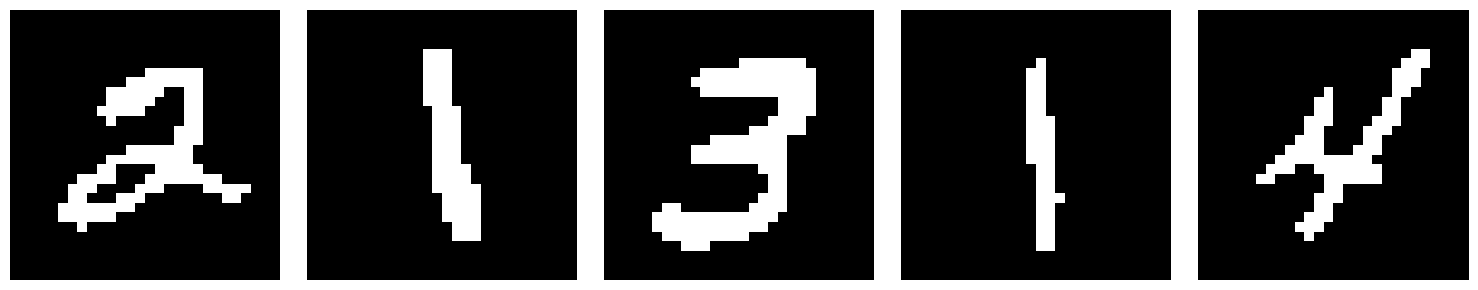

In [31]:
# Create a figure to display the images
plt.figure(figsize=(15, 3))

# Print the first few images in a row
for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(image_binary[i+5,:,:].to('cpu').numpy(), cmap='gray')
#         plt.imshow(image.squeeze()[i+300,:,:].to('cpu').numpy(), cmap='gray')
#         plt.title(f"Label: {label[i+5].item()}")
        plt.axis('off')
plt.tight_layout()
plt.show()

In [32]:
data = image_binary.reshape(-1,784).t()
data.shape

torch.Size([784, 60000])

In [33]:
col_list = []
for i in range(1,n_layer-1):
    col_list.append('Phi_Loss_Layer_'+str(i))
for i in range(n_layer-1):
    col_list.append('Theta_Loss_Layer_'+str(i))
for i in range(1,n_layer-1):
    col_list.append('Recog_H_Layer_'+str(i))
for i in range(1,n_layer-1):
    col_list.append('Recog_I_Layer_'+str(i))
for i in range(n_layer-1):
    col_list.append('Gen_H_Layer_'+str(i))
for i in range(1,n_layer-1):
    col_list.append('Gen_I_Layer_'+str(i))
col_list

['Phi_Loss_Layer_1',
 'Phi_Loss_Layer_2',
 'Phi_Loss_Layer_3',
 'Phi_Loss_Layer_4',
 'Phi_Loss_Layer_5',
 'Phi_Loss_Layer_6',
 'Phi_Loss_Layer_7',
 'Phi_Loss_Layer_8',
 'Phi_Loss_Layer_9',
 'Theta_Loss_Layer_0',
 'Theta_Loss_Layer_1',
 'Theta_Loss_Layer_2',
 'Theta_Loss_Layer_3',
 'Theta_Loss_Layer_4',
 'Theta_Loss_Layer_5',
 'Theta_Loss_Layer_6',
 'Theta_Loss_Layer_7',
 'Theta_Loss_Layer_8',
 'Theta_Loss_Layer_9',
 'Recog_H_Layer_1',
 'Recog_H_Layer_2',
 'Recog_H_Layer_3',
 'Recog_H_Layer_4',
 'Recog_H_Layer_5',
 'Recog_H_Layer_6',
 'Recog_H_Layer_7',
 'Recog_H_Layer_8',
 'Recog_H_Layer_9',
 'Recog_I_Layer_1',
 'Recog_I_Layer_2',
 'Recog_I_Layer_3',
 'Recog_I_Layer_4',
 'Recog_I_Layer_5',
 'Recog_I_Layer_6',
 'Recog_I_Layer_7',
 'Recog_I_Layer_8',
 'Recog_I_Layer_9',
 'Gen_H_Layer_0',
 'Gen_H_Layer_1',
 'Gen_H_Layer_2',
 'Gen_H_Layer_3',
 'Gen_H_Layer_4',
 'Gen_H_Layer_5',
 'Gen_H_Layer_6',
 'Gen_H_Layer_7',
 'Gen_H_Layer_8',
 'Gen_H_Layer_9',
 'Gen_I_Layer_1',
 'Gen_I_Layer_2',
 'Gen

In [34]:
len(col_list)

56

## Training

In [81]:
Analytic_MNIST_19_batch5000 = pd.read_csv('D:\Jupyter Notebook Files\Helmholtz Machine\Parameters_MNIST\Analytic_MNIST_19_batch5000_wsMI.csv', sep=",")
Analytic_MNIST_19_batch5000

,Phi_Loss_Layer_1,Phi_Loss_Layer_2,Phi_Loss_Layer_3,Phi_Loss_Layer_4,Phi_Loss_Layer_5,Phi_Loss_Layer_6,Phi_Loss_Layer_7,Phi_Loss_Layer_8,Phi_Loss_Layer_9,Phi_Loss_Layer_10,...,Gen_I_Layer_8,Gen_I_Layer_9,Gen_I_Layer_10,Gen_I_Layer_11,Gen_I_Layer_12,Gen_I_Layer_13,Gen_I_Layer_14,Gen_I_Layer_15,Gen_I_Layer_16,Gen_I_Layer_17
0,0.693148,0.693032,0.693090,0.693100,0.693130,0.693132,0.693127,0.693136,0.693143,0.693148,...,0.001068,0.000671,0.000671,0.000656,0.000427,0.000336,0.000145,0.000031,0.000015,0.000002
1,0.416684,0.446859,0.463437,0.472556,0.485796,0.494495,0.505219,0.515693,0.525189,0.531741,...,60.293945,49.442978,40.058060,30.717957,21.342834,12.250000,5.608658,1.989517,0.600635,0.166706
2,0.425594,0.445802,0.445166,0.418875,0.386619,0.403935,0.441433,0.484279,0.511787,0.528797,...,73.243970,57.637863,45.020630,34.166960,24.930420,17.114906,10.318176,4.668354,1.506021,0.376593
3,0.474290,0.421017,0.376259,0.327502,0.287375,0.293671,0.314802,0.359403,0.421778,0.496004,...,124.945940,93.498856,65.230150,44.680954,30.450912,20.091522,12.079246,5.930626,2.091242,0.574680
4,0.491218,0.405472,0.305729,0.272166,0.248445,0.252342,0.268194,0.291354,0.342480,0.401512,...,152.668270,121.722450,94.072365,64.818410,40.807970,25.359253,14.756401,7.085697,2.496077,0.719112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3194,0.316887,0.142002,0.271887,0.299576,0.159052,0.171283,0.131796,0.073425,0.011502,0.006069,...,192.260712,66.278412,21.194099,11.516308,8.668317,7.175815,5.999662,6.266127,4.711647,3.431929
3195,0.316492,0.142041,0.270882,0.300268,0.158102,0.171593,0.131138,0.073400,0.011431,0.006093,...,191.647079,65.697060,20.645599,11.020333,8.247291,6.878123,5.783613,6.169411,4.683298,3.427821
3196,0.316409,0.142103,0.270979,0.300216,0.159241,0.172041,0.131892,0.073620,0.011456,0.006070,...,192.007019,66.258499,21.289593,11.622706,8.722930,7.231071,6.008851,6.260319,4.694057,3.431510
3197,0.315993,0.142011,0.270648,0.300665,0.158557,0.172288,0.131316,0.073394,0.011480,0.006066,...,192.268463,66.149063,21.103767,11.435978,8.582994,7.128508,5.938245,6.223400,4.686720,3.423653


In [47]:
Analytic_MNIST_11_batch5000 = pd.read_csv('D:\Jupyter Notebook Files\Helmholtz Machine\Parameters_MNIST\Analytic_MNIST_11_batch5000_wsMI.csv', sep=",")
Analytic_MNIST_11_batch5000

,Phi_Loss_Layer_1,Phi_Loss_Layer_2,Phi_Loss_Layer_3,Phi_Loss_Layer_4,Phi_Loss_Layer_5,Phi_Loss_Layer_6,Phi_Loss_Layer_7,Phi_Loss_Layer_8,Phi_Loss_Layer_9,Theta_Loss_Layer_0,...,Gen_H_Layer_9,Gen_I_Layer_1,Gen_I_Layer_2,Gen_I_Layer_3,Gen_I_Layer_4,Gen_I_Layer_5,Gen_I_Layer_6,Gen_I_Layer_7,Gen_I_Layer_8,Gen_I_Layer_9
0,0.693147,0.693082,0.693132,0.693141,0.693148,0.693151,0.693150,0.693147,0.693148,0.359152,...,17.328680,0.181488,0.009216,0.008728,0.002625,0.000916,0.000336,0.000076,0.000031,0.000019
1,0.524282,0.518559,0.543901,0.578666,0.577057,0.597186,0.654764,0.673846,0.684986,0.251087,...,17.322939,19.664170,113.603910,87.237790,66.876250,40.936050,17.919434,6.579277,1.846710,0.472893
2,0.510264,0.517451,0.514186,0.568978,0.594951,0.614963,0.646290,0.663724,0.679560,0.235629,...,17.307455,18.360306,121.843414,98.682040,69.950350,45.004578,26.334381,11.209206,3.323971,0.829109
3,0.525836,0.510374,0.413777,0.529950,0.586450,0.627741,0.651412,0.665716,0.679487,0.212060,...,17.319470,23.719696,116.948425,109.079956,88.301710,51.055770,28.661057,12.550293,3.746391,0.951149
4,0.468139,0.511337,0.357364,0.440683,0.524880,0.606711,0.629107,0.660669,0.679099,0.200892,...,17.309568,26.869888,100.332214,94.661650,90.299710,54.601960,28.080505,11.782898,3.666630,0.961315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4793,0.286651,0.169738,0.275281,0.204051,0.238120,0.201621,0.192930,0.221761,0.345006,0.049007,...,16.047314,152.984055,173.646759,141.075073,162.944672,136.578430,119.167778,81.069305,35.214794,13.030739
4794,0.286407,0.169839,0.274892,0.204015,0.237919,0.201514,0.193220,0.221541,0.344822,0.049038,...,16.051956,152.842087,173.690948,140.850311,162.695511,136.430786,118.999336,81.015396,35.185371,13.019972
4795,0.286177,0.169950,0.275070,0.204195,0.237725,0.201729,0.192343,0.221527,0.344795,0.049061,...,16.059195,152.842834,173.635666,140.945129,162.814148,136.570465,119.129868,81.087875,35.238472,13.035965
4796,0.285981,0.170052,0.274939,0.204413,0.237896,0.201700,0.192503,0.222020,0.345513,0.049008,...,16.064484,152.794754,173.819824,140.977325,162.856979,136.617004,119.141968,81.088776,35.224243,13.046515


In [35]:
Analytic_MNIST_new_batch5000 = pd.read_csv('D:\Jupyter Notebook Files\Helmholtz Machine\Parameters_MNIST\Analytic_MNIST_new_batch5000.csv', sep=",")
Analytic_MNIST_new_batch5000

,Phi_Loss_Layer_1,Phi_Loss_Layer_2,Phi_Loss_Layer_3,Phi_Loss_Layer_4,Phi_Loss_Layer_5,Phi_Loss_Layer_6,Phi_Loss_Layer_7,Phi_Loss_Layer_8,Phi_Loss_Layer_9,Theta_Loss_Layer_0,...,Gen_H_Layer_9,Gen_I_Layer_1,Gen_I_Layer_2,Gen_I_Layer_3,Gen_I_Layer_4,Gen_I_Layer_5,Gen_I_Layer_6,Gen_I_Layer_7,Gen_I_Layer_8,Gen_I_Layer_9
0,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693148,0.693147,0.693147,...,17.328680,0.056961,0.000275,0.000153,0.000122,0.000061,0.000031,0.000000,0.000008,0.000000
1,0.433051,0.088980,0.129885,0.336500,0.661391,0.692569,0.693086,0.693137,0.693145,0.733592,...,17.328670,0.219311,0.007507,0.012344,0.070545,0.209625,0.043915,0.001343,0.000191,0.000042
2,0.416129,0.090037,0.163008,0.167657,0.622258,0.691826,0.693029,0.693119,0.693150,0.712715,...,17.328642,0.523369,0.007935,0.015984,0.044891,0.178558,0.091339,0.002991,0.000351,0.000061
3,0.424641,0.095837,0.186577,0.132144,0.620057,0.691436,0.692971,0.693108,0.693141,0.748648,...,17.328629,0.845078,0.008453,0.021046,0.040306,0.158844,0.091949,0.003937,0.000519,0.000095
4,0.428273,0.104279,0.173114,0.159998,0.625164,0.691247,0.692910,0.693106,0.693146,0.698957,...,17.328625,1.427055,0.009430,0.022728,0.046585,0.207657,0.087494,0.004440,0.000664,0.000122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6689,0.201977,0.323960,0.096444,0.086174,0.109483,0.135288,0.264563,0.245311,0.484456,0.057753,...,15.876793,148.746170,81.011887,93.279831,41.855736,32.884045,27.118580,21.976484,17.299055,10.266393
6690,0.201951,0.323857,0.096710,0.086140,0.109729,0.135156,0.264079,0.245531,0.484113,0.057633,...,15.870464,149.146133,81.232452,93.447815,41.949829,32.897633,27.120609,21.950743,17.301462,10.268412
6691,0.201760,0.324678,0.096383,0.086531,0.109106,0.135551,0.263535,0.246534,0.484180,0.057722,...,15.867100,149.286041,81.162369,93.447617,41.881840,32.906769,27.129906,21.987841,17.315533,10.255956
6692,0.201936,0.324142,0.096427,0.086259,0.109229,0.134969,0.264203,0.245119,0.484573,0.057643,...,15.874424,149.528336,81.212494,93.511230,41.925385,32.892567,27.114422,21.954800,17.317669,10.266495


In [66]:
# Phi,Theta = para_init(n_dz,dev)

In [82]:
para = torch.load('D:\Jupyter Notebook Files\Helmholtz Machine\Parameters_MNIST\Parameters_MNIST_19_batch5000_wsMI', dev,weights_only=True)
Phi = para['Phi']
Theta = para['Theta']

In [36]:
para = torch.load('D:\Jupyter Notebook Files\Helmholtz Machine\Parameters_MNIST\Parameters_MNIST_new_batch5000', dev,weights_only=True)
Phi = para['Phi']
Theta = para['Theta']

In [44]:
# Analytic_MNIST_new_batch5000_MI = pd.read_csv('D:\Jupyter Notebook Files\Helmholtz Machine\Parameters_MNIST\Analytic_MNIST_new_batch5000_MI.csv', sep=",")
# Analytic_MNIST_new_batch5000_MI

In [250]:
lr = 0.1
epoch = 10
batch_size = 5000
gen_batch_size = 10000
n_data = data.shape[1]
batch_num = int(n_data/batch_size)
batch_num

12

In [877]:
# for e in range(epoch):
#     Theta, Loss_sleep = wake_phase(Phi,Theta,data,lr,dev)
#     Phi, Loss_wake = sleep_phase(Phi,Theta,batch_size,lr,dev)
#     if e%1000 == 0:
#         print('Loss_wake:',Loss_wake,'    Loss_sleep:',Loss_sleep)

In [344]:
epoch = 10
# Epsilon = initialize_MI(data,Phi,lr,dev)
Epsilon = torch.ones(n_layer-2)*lr
Epsilon

tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000])

In [345]:
for e in range(epoch):
    Loss_W = 0
    Loss_S = 0
    index = np.random.permutation(n_data)
    for i in range(batch_num):
        if i%2 == 0:
            Theta, Loss_sleep = wake_phase_MI_batch(Phi,Theta,data[:,index[i*batch_size:(i+1)*batch_size]],lr,Epsilon,dev)
        else:
            Theta, Loss_sleep = wake_phase(Phi,Theta,data[:,index[i*batch_size:(i+1)*batch_size]],lr,dev)
        Phi, Loss_wake = sleep_phase(Phi,Theta,batch_size,lr,dev)
        Loss_W += Loss_wake
        Loss_S += Loss_sleep

    print('Loss_wake:',Loss_W/batch_num,'    Loss_sleep:',Loss_S/batch_num)
    stat = []
    stat = stat + list((Loss_wake[1:]/batch_num).to('cpu').numpy())
    stat = stat + list((Loss_sleep/batch_num).to('cpu').numpy())

    Recog_sample, H_Y_wake, H_YX_wake = wake_sample(Phi,data[:,index[:10000]],dev)
    Gen_sample, H_Y_sleep, H_YX_sleep = sleep_sample(Theta,gen_batch_size,dev)

    stat = stat + list(H_Y_wake.to('cpu').numpy()) + list((H_Y_wake - H_YX_wake).to('cpu').numpy()) \
            + list(H_Y_sleep.to('cpu').numpy()) + list((H_Y_sleep - H_YX_sleep)[:-1].to('cpu').numpy())
    Analytic_MNIST_new_batch5000_MI.loc[len(Analytic_MNIST_new_batch5000_MI)] = stat
    torch.cuda.empty_cache()

Loss_wake: tensor([0.0000, 0.2111, 0.3416, 0.0975, 0.0864, 0.1089, 0.1367, 0.2669, 0.2448,
        0.4850])     Loss_sleep: tensor([0.0612, 0.1785, 0.3175, 0.1301, 0.0939, 0.1155, 0.1395, 0.2629, 0.2774,
        0.6435])
Loss_wake: tensor([0.0000, 0.2102, 0.3571, 0.0989, 0.0864, 0.1085, 0.1388, 0.2698, 0.2455,
        0.4856])     Loss_sleep: tensor([0.0613, 0.1801, 0.3236, 0.1276, 0.0931, 0.1130, 0.1395, 0.2611, 0.2764,
        0.6431])
Loss_wake: tensor([0.0000, 0.2070, 0.3610, 0.1001, 0.0862, 0.1082, 0.1399, 0.2714, 0.2476,
        0.4858])     Loss_sleep: tensor([0.0628, 0.1777, 0.3223, 0.1268, 0.0938, 0.1119, 0.1404, 0.2607, 0.2754,
        0.6439])
Loss_wake: tensor([0.0000, 0.2032, 0.3597, 0.1011, 0.0859, 0.1084, 0.1408, 0.2730, 0.2469,
        0.4871])     Loss_sleep: tensor([0.0635, 0.1744, 0.3189, 0.1260, 0.0933, 0.1112, 0.1405, 0.2603, 0.2751,
        0.6442])
Loss_wake: tensor([0.0000, 0.1996, 0.3574, 0.1015, 0.0858, 0.1085, 0.1419, 0.2747, 0.2479,
        0.4872])     Loss

In [133]:
Analytic_MNIST_new_batch5000_MI

,Phi_Loss_Layer_1,Phi_Loss_Layer_2,Phi_Loss_Layer_3,Phi_Loss_Layer_4,Phi_Loss_Layer_5,Phi_Loss_Layer_6,Phi_Loss_Layer_7,Phi_Loss_Layer_8,Phi_Loss_Layer_9,Theta_Loss_Layer_0,...,Gen_H_Layer_9,Gen_I_Layer_1,Gen_I_Layer_2,Gen_I_Layer_3,Gen_I_Layer_4,Gen_I_Layer_5,Gen_I_Layer_6,Gen_I_Layer_7,Gen_I_Layer_8,Gen_I_Layer_9
0,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693148,0.693147,0.693147,...,17.328680,0.056961,0.000275,0.000153,0.000122,0.000061,0.000031,0.000000,0.000008,0.000000
1,0.433051,0.088980,0.129885,0.336500,0.661391,0.692569,0.693086,0.693137,0.693145,0.733592,...,17.328670,0.219311,0.007507,0.012344,0.070545,0.209625,0.043915,0.001343,0.000191,0.000042
2,0.416129,0.090037,0.163008,0.167657,0.622258,0.691826,0.693029,0.693119,0.693150,0.712715,...,17.328642,0.523369,0.007935,0.015984,0.044891,0.178558,0.091339,0.002991,0.000351,0.000061
3,0.424641,0.095837,0.186577,0.132144,0.620057,0.691436,0.692971,0.693108,0.693141,0.748648,...,17.328629,0.845078,0.008453,0.021046,0.040306,0.158844,0.091949,0.003937,0.000519,0.000095
4,0.428273,0.104279,0.173114,0.159998,0.625164,0.691247,0.692910,0.693106,0.693146,0.698957,...,17.328625,1.427055,0.009430,0.022728,0.046585,0.207657,0.087494,0.004440,0.000664,0.000122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6699,0.003112,0.005803,0.001656,0.001415,0.001850,0.002459,0.004662,0.004371,0.008325,0.000978,...,16.325050,119.851837,100.888107,137.442856,51.669865,36.748440,32.262592,27.049068,19.822273,12.127749
6700,0.003058,0.005702,0.001657,0.001409,0.001866,0.002419,0.004667,0.004317,0.008340,0.001002,...,16.402348,134.087830,110.081207,160.698776,59.928867,44.426807,35.892879,27.753883,21.919922,11.925347
6701,0.003029,0.005591,0.001665,0.001391,0.001873,0.002441,0.004696,0.004343,0.008419,0.000982,...,16.471428,136.855347,100.369118,147.248108,53.498348,36.844505,31.540535,22.004963,20.858440,10.124063
6702,0.002998,0.005501,0.001640,0.001374,0.001873,0.002411,0.004612,0.004351,0.008372,0.000985,...,16.527592,126.288147,108.085243,153.993927,60.219028,42.962776,36.238693,28.606943,21.870825,11.158409


In [1013]:
# Analytic_MNIST_new_batch5000_MI.to_csv('D:\Jupyter Notebook Files\Helmholtz Machine\Parameters_MNIST\Analytic_MNIST_new_batch5000_MI.csv', index = False)

In [362]:
# parameters = {'Phi': Phi, 'Theta': Theta}
# torch.save(parameters,'D:\Jupyter Notebook Files\Helmholtz Machine\Parameters_MNIST\Parameters_MNIST_new_batch5000_MI')

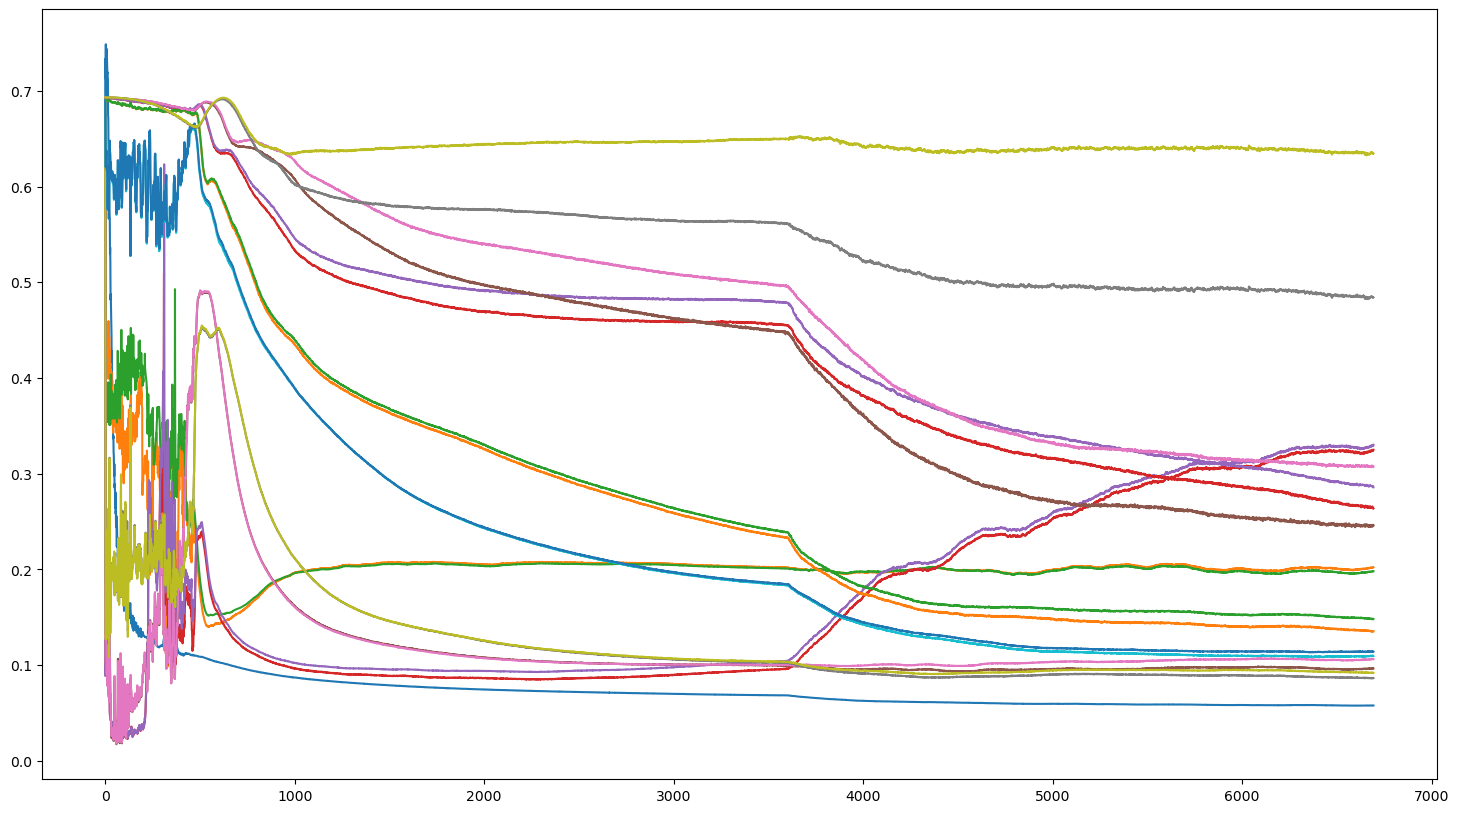

In [37]:
Analytic = Analytic_MNIST_new_batch5000
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(np.array(Analytic['Theta_Loss_Layer_'+str(0)]),label = 'Theta_Loss_Layer_'+str(0))
for i in range(1,n_layer-1):
    ax.plot(np.array(Analytic['Phi_Loss_Layer_'+str(i)]),label = 'Phi_Loss_Layer_'+str(i))
    ax.plot(np.array(Analytic['Theta_Loss_Layer_'+str(i)]),label = 'Theta_Loss_Layer_'+str(i))
# ax.legend()
plt.show()

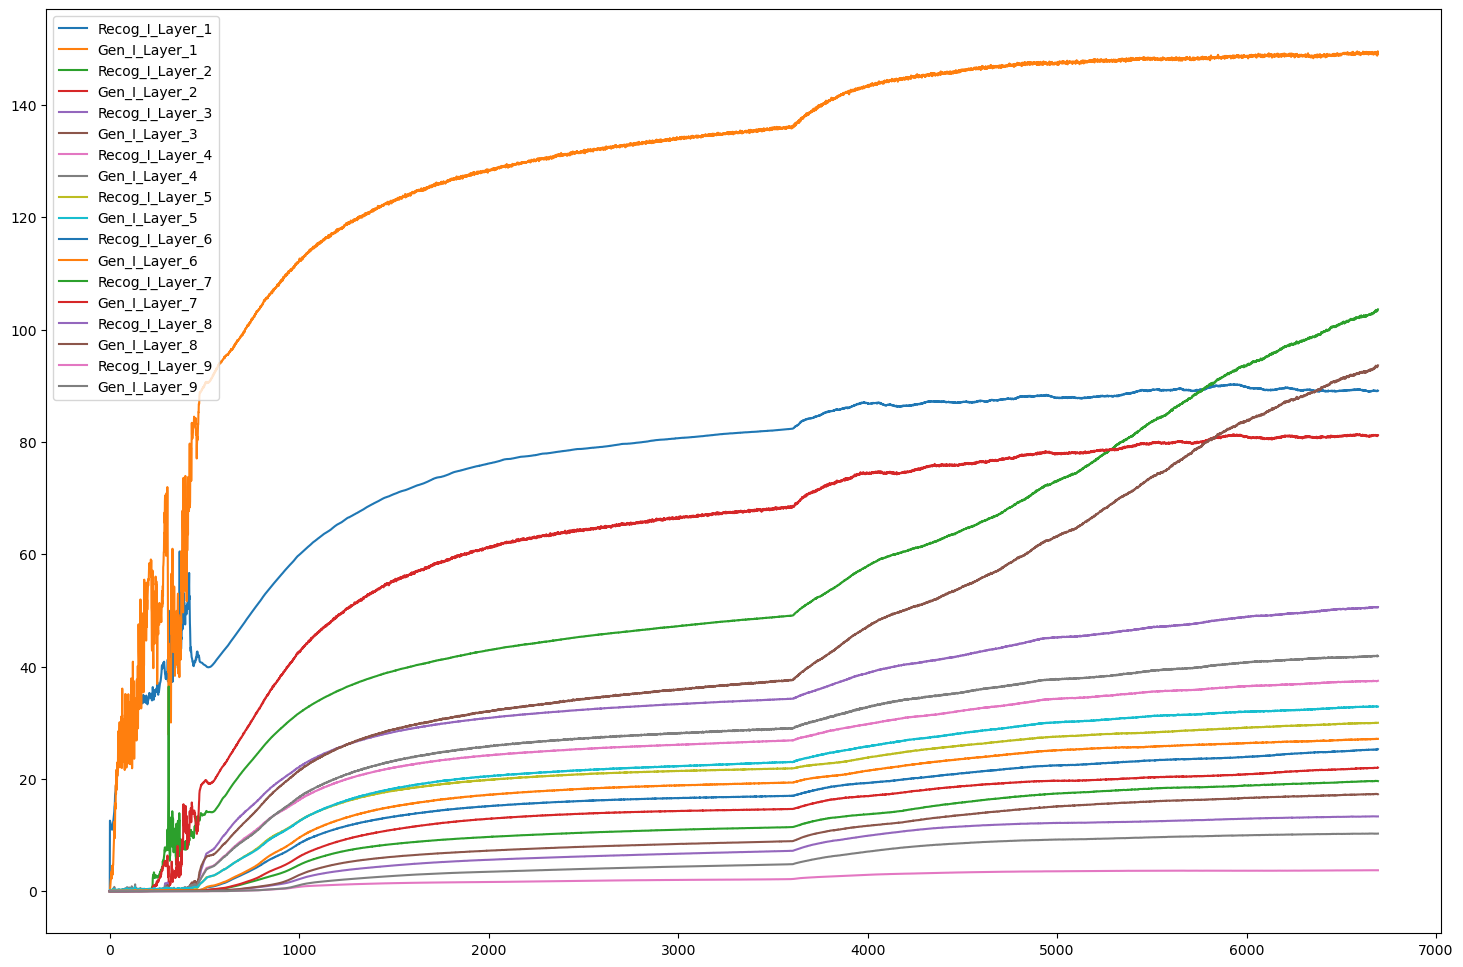

In [38]:
fig, ax = plt.subplots(figsize=(18, 12))
for i in range(1,n_layer-1):
    ax.plot(np.array(Analytic['Recog_I_Layer_'+str(i)]),label = 'Recog_I_Layer_'+str(i))
    ax.plot(np.array(Analytic['Gen_I_Layer_'+str(i)]),label = 'Gen_I_Layer_'+str(i))
ax.legend()
plt.show()

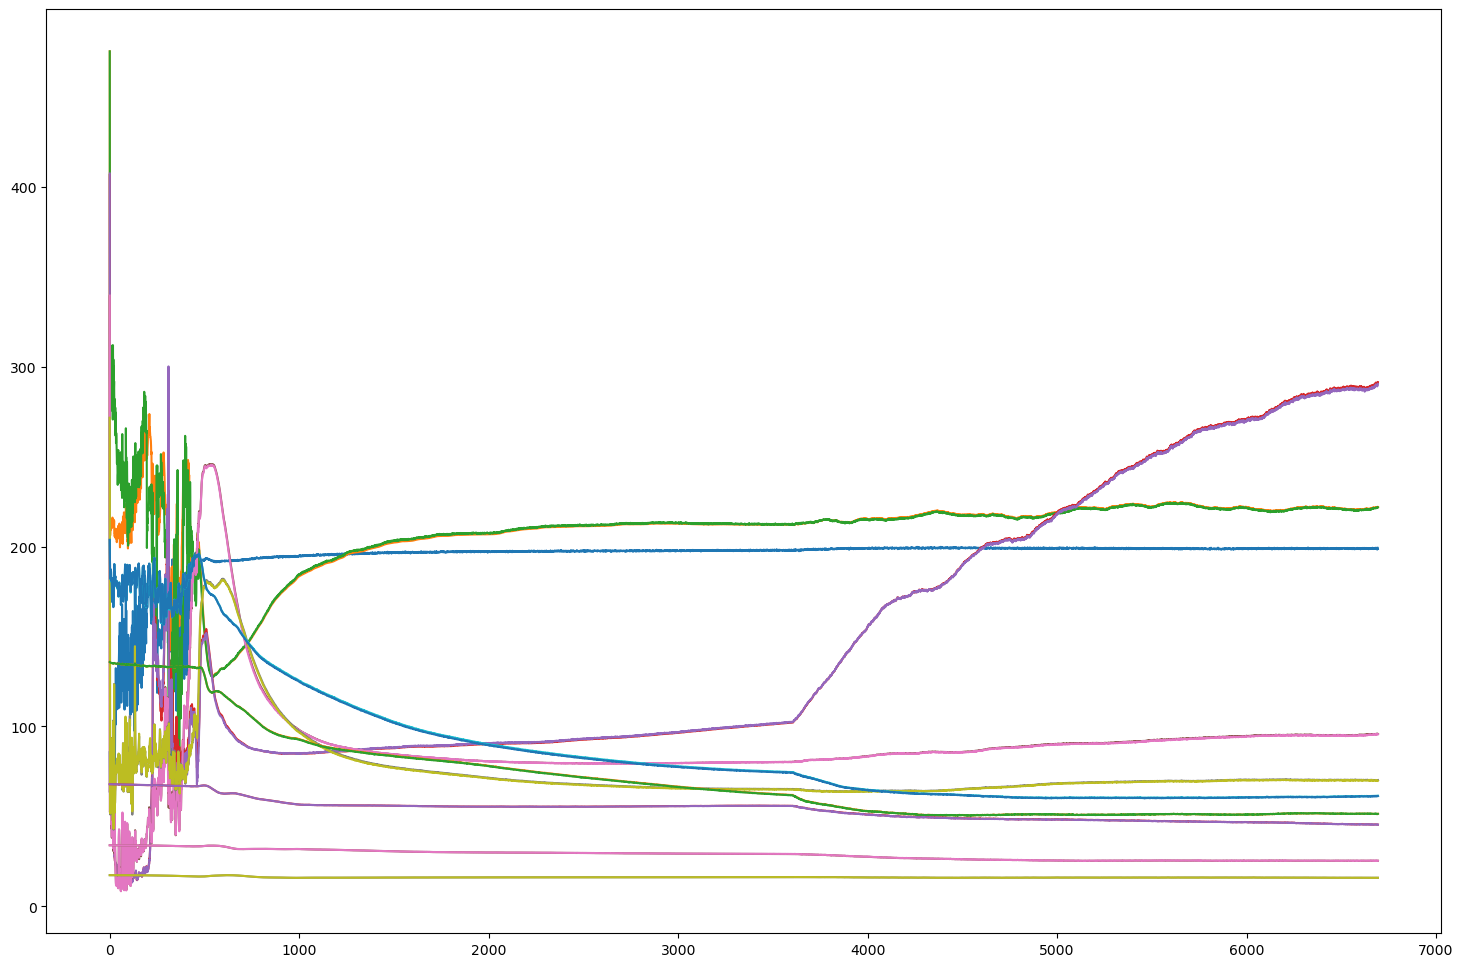

In [39]:
fig, ax = plt.subplots(figsize=(18, 12))
ax.plot(np.array(Analytic['Gen_H_Layer_0']),label = 'Gen_H_Layer_0')
for i in range(1,n_layer-1):
    ax.plot(np.array(Analytic['Recog_H_Layer_'+str(i)]),label = 'Recog_H_Layer_'+str(i))
    ax.plot(np.array(Analytic['Gen_H_Layer_'+str(i)]),label = 'Gen_H_Layer_'+str(i))
# ax.legend()
plt.show()

In [40]:
n_dz[:-1] * np.log(2)

tensor([543.4274, 475.4990, 407.5706, 339.6421, 271.7137, 203.7853, 135.8568,
         67.9284,  33.9642,  17.3287])

In [41]:
gen_batch_size = 5000
Recog_sample, H_Y_wake, H_YX_wake = wake_sample(Phi,data[:,:5000],dev)
Gen_sample, H_Y_sleep, H_YX_sleep = sleep_sample(Theta,gen_batch_size,dev)

Layer 0 Data_dist D_KL: 0.4917
Layer 0 Gen_dist D_KL: 0.8647
Layer 1 Recognition Distribution D_KL: 0.1282 H(Y): 222.2368 H(Y|X): 133.1364 I_XY: 89.1004
Layer 1 Generative  Distribution D_KL: 0.1268 H(Y): 221.956 H(Y|X): 140.7605 I_XY: 149.1408
Layer 2 Recognition Distribution D_KL: 0.1963 H(Y): 291.6346 H(Y|X): 187.927 I_XY: 103.7076
Layer 2 Generative  Distribution D_KL: 0.1989 H(Y): 289.6339 H(Y|X): 195.8412 I_XY: 81.1954
Layer 3 Recognition Distribution D_KL: 0.2749 H(Y): 96.1812 H(Y|X): 45.4452 I_XY: 50.7361
Layer 3 Generative  Distribution D_KL: 0.1935 H(Y): 95.9561 H(Y|X): 53.9964 I_XY: 93.7927
Layer 4 Recognition Distribution D_KL: 0.3007 H(Y): 70.0296 H(Y|X): 32.5489 I_XY: 37.4807
Layer 4 Generative  Distribution D_KL: 0.2078 H(Y): 69.817 H(Y|X): 36.8627 I_XY: 41.9597
Layer 5 Recognition Distribution D_KL: 0.0975 H(Y): 61.4776 H(Y|X): 31.4039 I_XY: 30.0738
Layer 5 Generative  Distribution D_KL: 0.0775 H(Y): 61.2822 H(Y|X): 34.0996 I_XY: 32.9543
Layer 6 Recognition Distribution

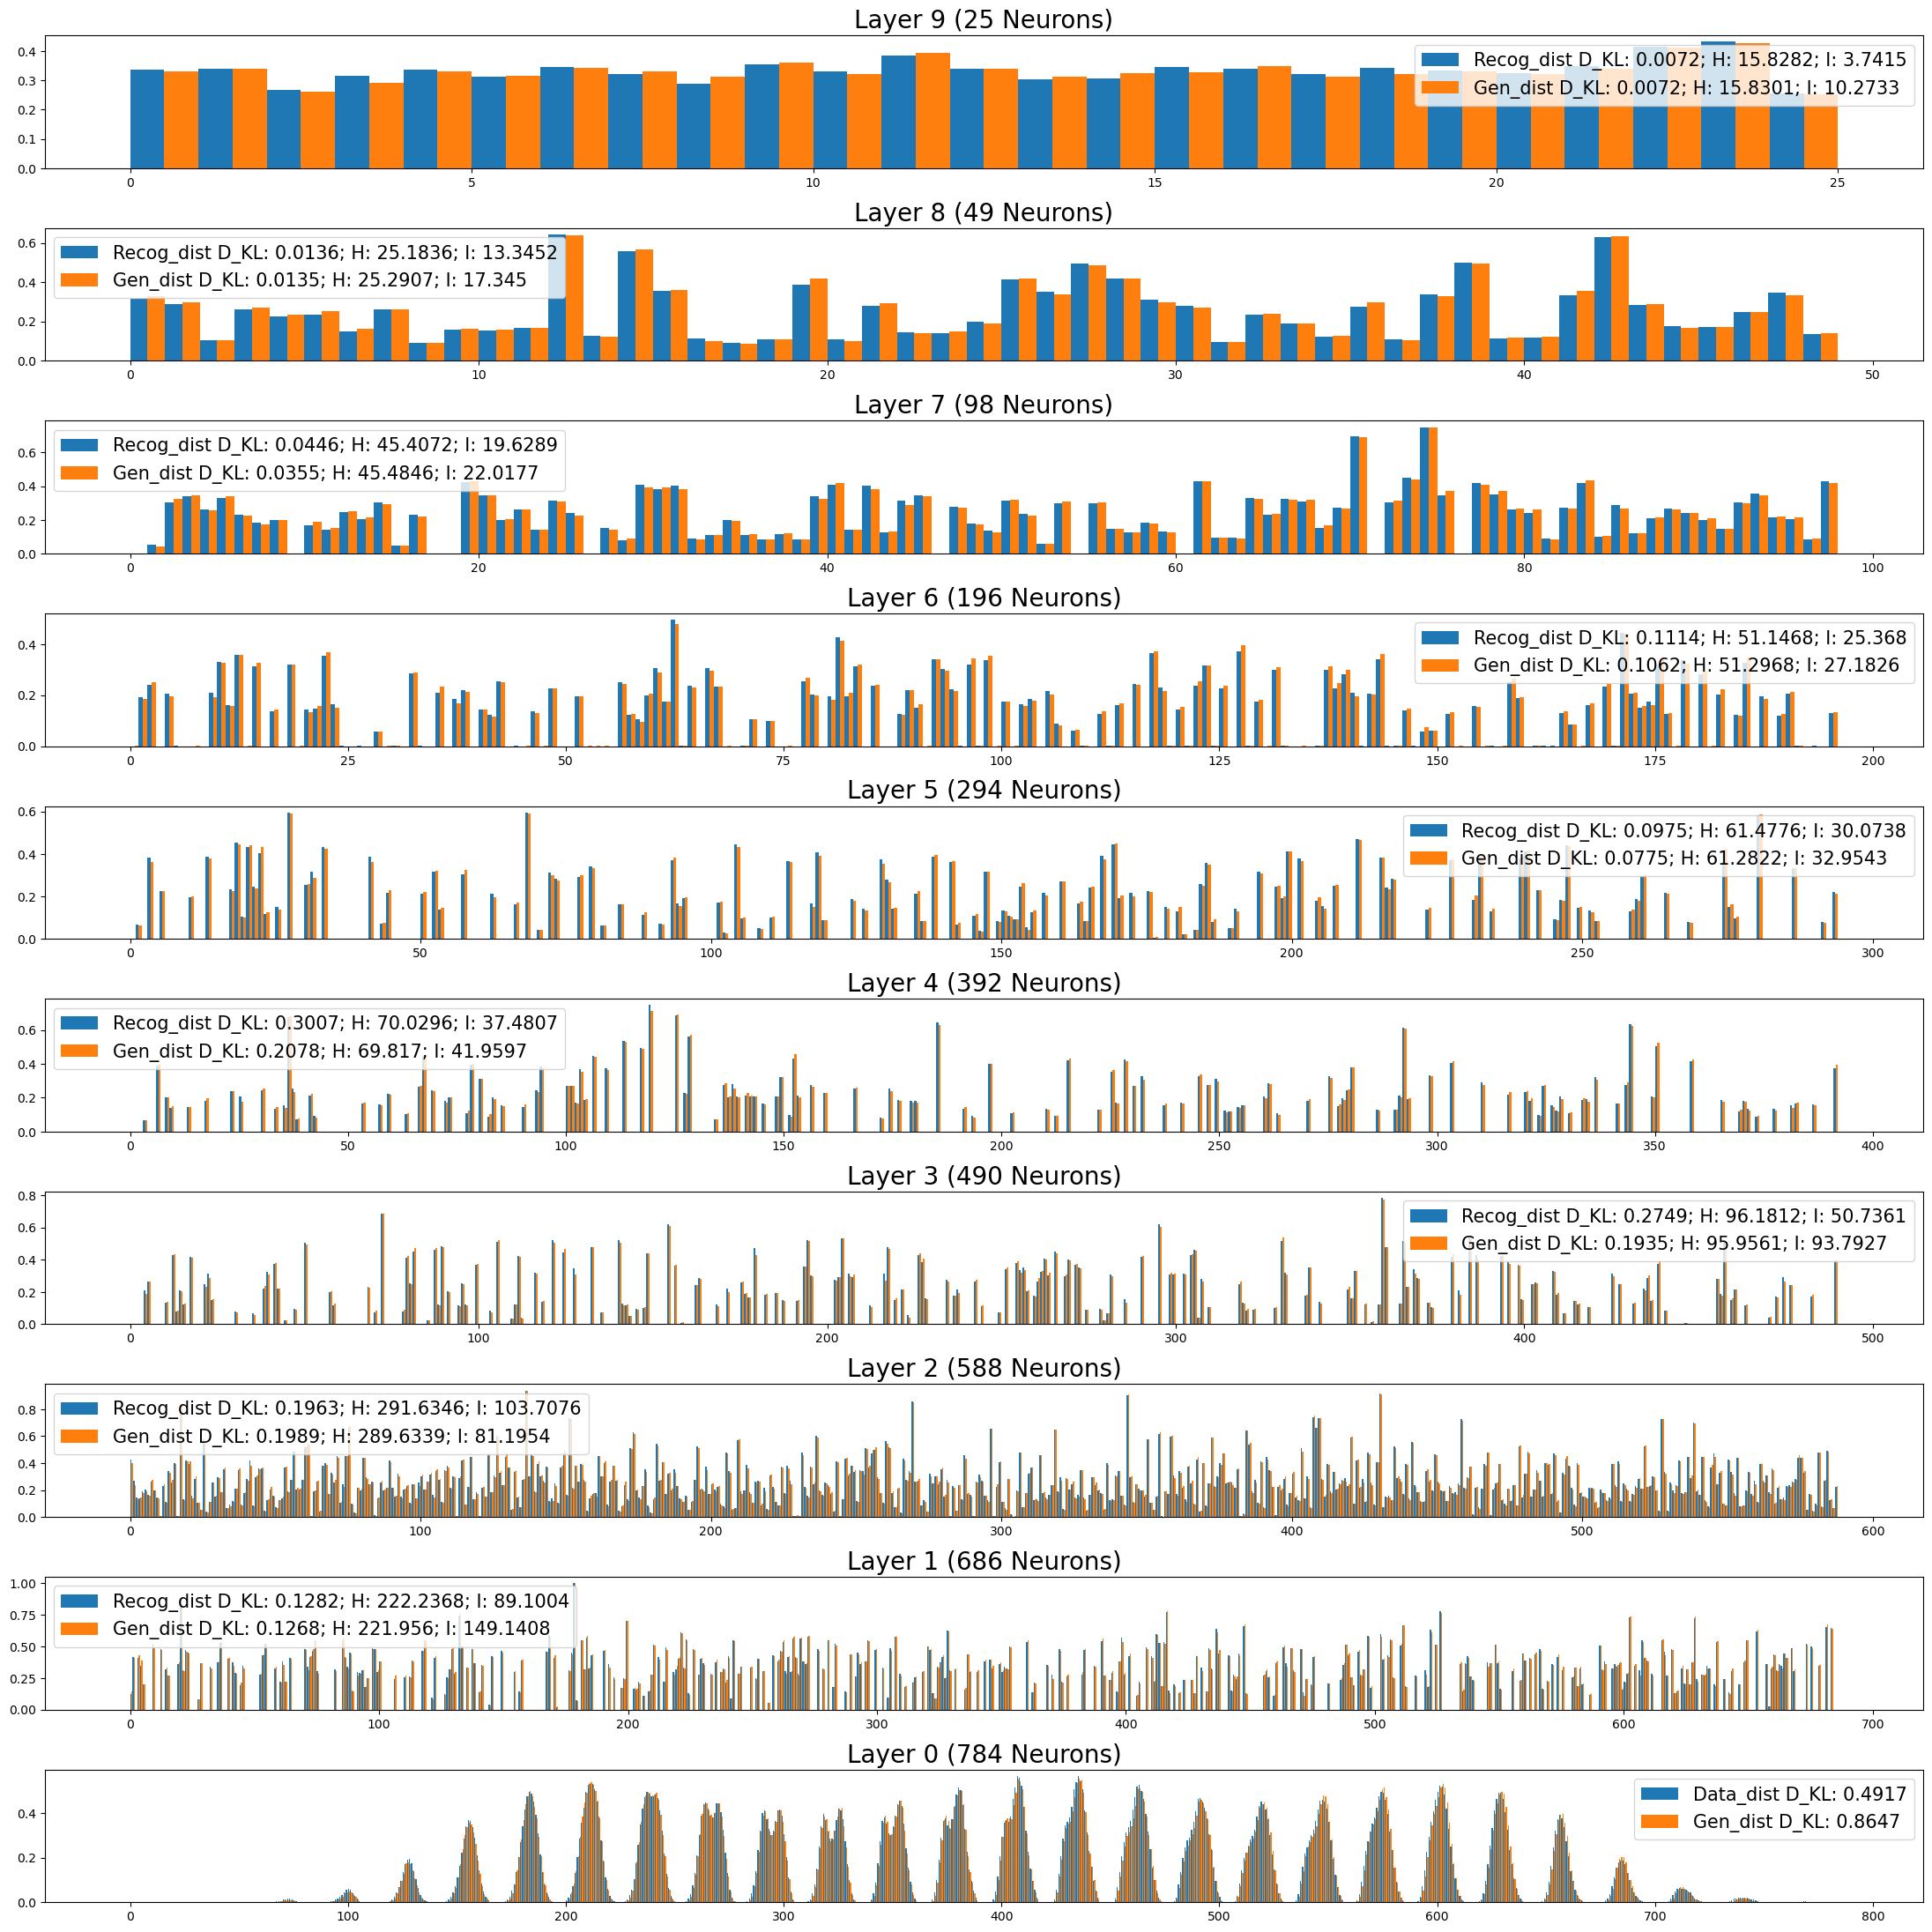

In [42]:
fig_ct, ax_ct = plt.subplots(n_layer-1, 1, figsize=(22, 22))
H_Y_wake = H_Y_wake.to('cpu').numpy()
H_YX_wake = H_YX_wake.to('cpu').numpy()
I_wake = H_Y_wake - H_YX_wake
H_Y_sleep = H_Y_sleep.to('cpu').numpy()
H_YX_sleep = H_YX_sleep.to('cpu').numpy()
I_sleep = H_Y_sleep - H_YX_sleep

for i in range(n_layer-1):
    dist_w = Recog_sample['Layer_'+str(i)].float().mean(axis=1)
    dist_s = Gen_sample['Layer_'+str(i)].float().mean(axis=1)
    D_KL_w = KL_divergence_bernoulli(dist_s,dist_w).item()
    D_KL_s = KL_divergence_bernoulli(dist_w,dist_s).item()
    
    if i > 0:
        print("Layer "+str(i), "Recognition Distribution D_KL: "+str(np.around(D_KL_w,4)),\
          "H(Y): "+str(np.around(H_Y_wake[i-1],4)), "H(Y|X): "+str(np.around(H_YX_wake[i-1],4)),"I_XY: "+str(np.around(I_wake[i-1],4)))
        print("Layer "+str(i),"Generative  Distribution D_KL: "+str(np.around(D_KL_s,4)),\
          "H(Y): "+str(np.around(H_Y_sleep[i],4)), "H(Y|X): "+str(np.around(H_YX_sleep[i],4)),"I_XY: "+str(np.around(I_sleep[i-1],4)))
        ax_ct[n_layer-2-i].bar(np.arange(n_dz[i]),dist_w.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Recog_dist D_KL: " + str(np.around(D_KL_w,4))+"; H: "+ \
                               str(np.around(H_Y_wake[i-1],4))+ "; I: "+ str(np.around(I_wake[i-1],4)))
        ax_ct[n_layer-2-i].bar(np.arange(n_dz[i])+0.5,dist_s.to('cpu').numpy(),width=0.5,align='edge',\
                          label = "Gen_dist D_KL: " + str(np.around(D_KL_s,4))+"; H: "+ \
                               str(np.around(H_Y_sleep[i],4))+ "; I: "+ str(np.around(I_sleep[i-1],4)))
    else:
        print("Layer "+str(i), "Data_dist D_KL: "+str(np.around(D_KL_w,4)))
        ax_ct[n_layer-2-i].bar(np.arange(n_dz[i]),dist_w.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Data_dist D_KL: " + str(np.around(D_KL_w,4)))
        
        print("Layer "+str(i), "Gen_dist D_KL: "+str(np.around(D_KL_s,4)))
        ax_ct[n_layer-2-i].bar(np.arange(n_dz[i])+0.5,dist_s.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Gen_dist D_KL: " + str(np.around(D_KL_s,4)))

    ax_ct[n_layer-2-i].set_title("Layer "+str(i)+" ("+ str(n_dz[i].item())+" Neurons)",fontsize=20)
    ax_ct[n_layer-2-i].legend(fontsize=15)
    
plt.tight_layout(pad=1)    
plt.show()

In [69]:
gen_batch_size = 10
Gen_sample, H_Y_sleep, H_YX_sleep = sleep_sample(Theta,gen_batch_size,dev)
gen = Gen_sample["Layer_0"]
gen.shape

torch.Size([784, 10])

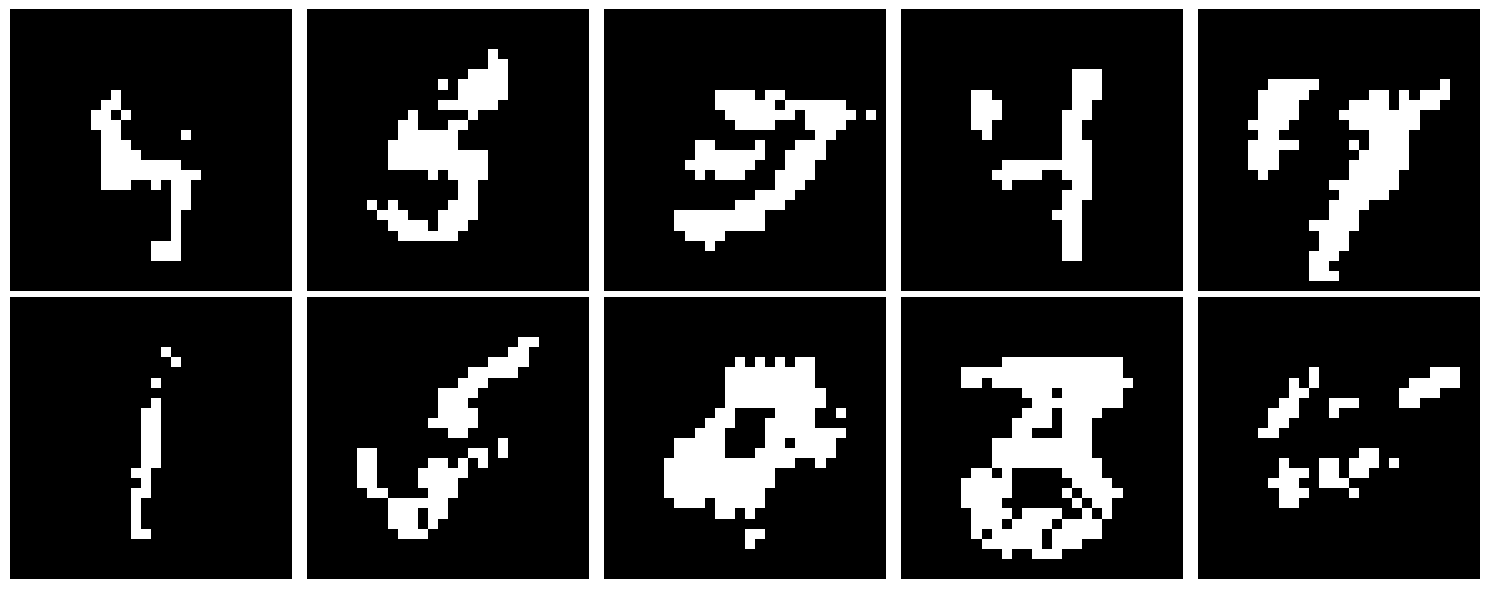

In [70]:
# Create a figure to display the images
fig, axs = plt.subplots(2, 5,figsize=(15, 6))
for i in range(2):
    for j in range(5):
        axs[i,j].imshow(gen[:,i*5+j].reshape(28,28).to('cpu').numpy(), cmap='gray')
        axs[i,j].axis('off')
plt.tight_layout()
plt.show()

In [57]:
A = np.array([[1,2,3,4,0,0,0,0],
              [0,1,2,3,4,0,0,0],
              [0,0,1,2,3,4,0,0],
              [0,0,0,1,2,3,4,0],
              [0,0,0,0,1,2,3,4]])

In [58]:
np.linalg.svd(A)

(array([[ 3.48018609e-01,  5.75560546e-01, -5.79800353e-01,
          4.10767645e-01,  2.06675104e-01],
        [ 4.84622273e-01,  4.10767645e-01,  1.11713336e-01,
         -5.75560546e-01, -5.02654337e-01],
        [ 5.36701594e-01,  1.66533454e-16,  5.50184844e-01,
         -9.43689571e-16,  6.39724969e-01],
        [ 4.84622273e-01, -4.10767645e-01,  1.11713336e-01,
          5.75560546e-01, -5.02654337e-01],
        [ 3.48018609e-01, -5.75560546e-01, -5.79800353e-01,
         -4.10767645e-01,  2.06675104e-01]]),
 array([8.96572568, 6.43575359, 3.86492617, 2.75337533, 2.38287823]),
 array([[ 0.03881656,  0.13168588,  0.28441668,  0.49120025,  0.54271759,
          0.47923733,  0.33266074,  0.15526623],
        [ 0.08943173,  0.24268933,  0.39594694,  0.48537866,  0.03822004,
         -0.37034109, -0.5235987 , -0.3577269 ],
        [-0.15001589, -0.2711274 , -0.24988564, -0.19973949,  0.45047023,
          0.35609443, -0.33443012, -0.60006357],
        [ 0.14918694,  0.08933571,  0.0